In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_scheduler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

C:\Users\derta\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = pd.read_csv('data/training.csv')
val_data = pd.read_csv('data/validation.csv')
test_data = pd.read_csv('data/test.csv')

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_data['label_encoded'] = label_encoder.fit_transform(train_data['label'])
val_data['label_encoded'] = label_encoder.transform(val_data['label'])
test_data['label_encoded'] = label_encoder.transform(test_data['label'])

print("Classes:", label_encoder.classes_)

Classes: [0 1 2 3 4 5]


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label)
        }

train_dataset = TextDataset(train_data['text'], train_data['label_encoded'], tokenizer)
val_dataset = TextDataset(val_data['text'], val_data['label_encoded'], tokenizer)
test_dataset = TextDataset(test_data['text'], test_data['label_encoded'], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=len(label_encoder.classes_)
).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
optimizer = AdamW(model.parameters(), lr=5e-5)

num_training_steps = len(train_loader) * 5
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

criterion = torch.nn.CrossEntropyLoss()


C:\Users\derta\AppData\Roaming\Python\Python312\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [6]:
import os


def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs=5):
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pt")


if os.path.exists("best_model.pt"):
    model.load_state_dict(torch.load("best_model.pt"))
    print("Модель успешно загружена из файла")
else:
    print("Файл модели не найден. Начинаем обучение...")
    train_model(model, train_loader, val_loader, optimizer, scheduler, criterion)


Файл модели не найден. Начинаем обучение...
Epoch 1: Train Loss: 0.4838, Validation Loss: 0.1633
Epoch 2: Train Loss: 0.1230, Validation Loss: 0.1244
Epoch 3: Train Loss: 0.0904, Validation Loss: 0.1220
Epoch 4: Train Loss: 0.0703, Validation Loss: 0.1406
Epoch 5: Train Loss: 0.0538, Validation Loss: 0.1419


C:\Users\derta\AppData\Local\Temp\ipykernel_20268\857288583.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


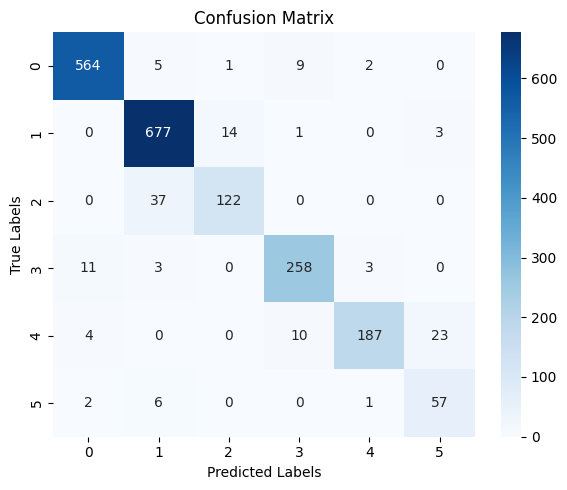

Prediction Results:
Total Samples: 2000
Correct Predictions: 1865
Accuracy: 93.25%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       581
           1       0.93      0.97      0.95       695
           2       0.89      0.77      0.82       159
           3       0.93      0.94      0.93       275
           4       0.97      0.83      0.90       224
           5       0.69      0.86      0.77        66

    accuracy                           0.93      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.93      0.93      0.93      2000


Additional Metrics:
Precision: 0.9347
Recall: 0.9325
F1-score: 0.9322


In [11]:
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_fscore_support
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, label_encoder, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.load_state_dict(torch.load("best_model.pt"))
    model.to(device)
    model.eval()
    
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            
            predictions.extend(preds)
            true_labels.extend(batch['label'].numpy())
    
    predicted_labels = label_encoder.inverse_transform(predictions)
    true_labels_str = label_encoder.inverse_transform(true_labels)
    
    total_samples = len(true_labels)
    correct_predictions = (np.array(predicted_labels) == np.array(true_labels_str)).sum()
    accuracy = correct_predictions / total_samples * 100
    
    target_names = [str(cls) for cls in label_encoder.classes_]
    class_report = classification_report(
        true_labels_str, 
        predicted_labels, 
        target_names=target_names
    )
    
    cmatrix = confusion_matrix(true_labels_str, predicted_labels)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels_str, 
        predicted_labels, 
        average='weighted'
    )
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cmatrix, 
        annot=True, 
        fmt="d", 
        cmap="Blues", 
        xticklabels=target_names,
        yticklabels=target_names
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()
    
    print("Prediction Results:")
    print(f"Total Samples: {total_samples}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.2f}%")
    
    print("\nClassification Report:")
    print(class_report)
    
    print("\nAdditional Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'total_samples': total_samples,
        'correct_predictions': correct_predictions,
        'confusion_matrix': cmatrix,
        'classification_report': class_report,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

results = evaluate_model(model, test_loader, label_encoder)

In [ ]:
def predict_single_text(model, text, tokenizer, label_encoder, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    encoded_input = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        predicted_class_idx = torch.argmax(outputs.logits, dim=1).item()
    
    predicted_label = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    return {
        'input_text': text,
        'predicted_label': predicted_label
    }

single_text = "no no no mister fish you don't go to your family. You go to this tazik"
result = predict_single_text(model, single_text, tokenizer, label_encoder)
print(f"Input Text: {result['input_text']}")
print(f"Predicted Label: {result['predicted_label']}")

Input Text: no no no mister fish you don't go to your family. You go to this tazik
Predicted Label: 3
